In [5]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *

In [6]:
spark_master_private_ip = '192.168.2.122'

spark = SparkSession.builder\
        .master(f'spark://{spark_master_private_ip}:7077') \
        .appName('group-9_project')\
        .config('spark.dynamicAllocation.enabled', True)\
        .config('spark.dynamicAllocation.shuffleTracking.enabled',True)\
        .config('spark.shuffle.service.enabled', True)\
        .config('spark.dynamicAllocation.executorIdleTimeout','30s')\
        .config('spark.cores.max', 4)\
        .getOrCreate()

sql_context = SQLContext(spark.sparkContext)

In [7]:
# Loads the Reddit dataset containing comments as JSON documents from HDFS into a DataFrame 
# and stores it in cache memory to increase speed.
reddit_comments = sql_context.read.json(f'hdfs://{spark_master_private_ip}:9000/group-9').cache()

In [8]:
# Prints the schema of the Reddit comments. 
reddit_comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: boolean (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [9]:
# Extracts the documents (comment bodies) of the Reddit comments. 
documents = reddit_comments.select(col('body').alias('document'))

In [10]:
# Prints the documents in the document corpus.
documents.show()

+--------------------+
|            document|
+--------------------+
|A look at Vietnam...|
|The site states "...|
|Jython related to...|
|           [deleted]|
|Saft is by far th...|
|           [deleted]|
|How to take panor...|
|I donât know wh...|
|LinkIt by Marc, a...|
|Making websites r...|
|On the bright sid...|
|Like a lot of peo...|
|This is comment t...|
|           [deleted]|
|           [deleted]|
|           [deleted]|
|           [deleted]|
|It's a New York T...|
|[Here's the copy ...|
|The best thing ab...|
+--------------------+
only showing top 20 rows



In [11]:
# Pre-processes each document in the document corpus. 
def pre_process(documents):
    
    # 1. Filters out deleted/removed documents
    # 2. Removes URLs in the documents.
    # 3. Converts the documents into lower case.
    # 4. Removes non-alphabetic characters from the documents.
    # 5. Trims the documents (removes leading and trailing spaces) 
    # 6. Removes empty documents 
    # 7. Tokenizes the documents (splits on whitespace)
    
    return documents.filter((col('document') != '[deleted]') & (col('document') != '[removed]')) \
                    .withColumn('document', regexp_replace(col('document'), 'http:\S+|www\.\S+', '')) \
                    .withColumn('document', lower(col('document'))) \
                    .withColumn('document', regexp_replace(col('document'), "[^a-z'\s]", ' ')) \
                    .withColumn('document', regexp_replace(col('document'), "^\s*|\s*$", '')) \
                    .filter(length(col('document')) > 0) \
                    .withColumn('document', split(col('document'), '\s+')) 

In [12]:
# Pre-processes each document in the document corpus.
documents = pre_process(documents)
documents.show()

+--------------------+
|            document|
+--------------------+
|[a, look, at, vie...|
|[the, site, state...|
|[jython, related,...|
|[saft, is, by, fa...|
|[how, to, take, p...|
|[i, don, t, know,...|
|[linkit, by, marc...|
|[making, websites...|
|[on, the, bright,...|
|[like, a, lot, of...|
|[this, is, commen...|
|[it's, a, new, yo...|
|[here's, the, cop...|
|[the, best, thing...|
|[you, can, rank, ...|
|[just, testing, t...|
|            [ye, ye]|
|[we, didn't, tort...|
|[interesting, art...|
|[reddit, got, a, ...|
+--------------------+
only showing top 20 rows



In [13]:
# Adds unique identifiers for all documents in the document corpus.  
documents = documents.withColumn('doc_id', monotonically_increasing_id())
documents.show()

+--------------------+------+
|            document|doc_id|
+--------------------+------+
|[a, look, at, vie...|     0|
|[the, site, state...|     1|
|[jython, related,...|     2|
|[saft, is, by, fa...|     3|
|[how, to, take, p...|     4|
|[i, don, t, know,...|     5|
|[linkit, by, marc...|     6|
|[making, websites...|     7|
|[on, the, bright,...|     8|
|[like, a, lot, of...|     9|
|[this, is, commen...|    10|
|[it's, a, new, yo...|    11|
|[here's, the, cop...|    12|
|[the, best, thing...|    13|
|[you, can, rank, ...|    14|
|[just, testing, t...|    15|
|            [ye, ye]|    16|
|[we, didn't, tort...|    17|
|[interesting, art...|    18|
|[reddit, got, a, ...|    19|
+--------------------+------+
only showing top 20 rows



In [14]:
# Unfolds each document giving a set of tokens belonging to each document.
unfolded_documents = documents.select(col('document'), col('doc_id'), explode(col('document')).alias('token')) 
unfolded_documents.show()

+--------------------+------+--------------+
|            document|doc_id|         token|
+--------------------+------+--------------+
|[a, look, at, vie...|     0|             a|
|[a, look, at, vie...|     0|          look|
|[a, look, at, vie...|     0|            at|
|[a, look, at, vie...|     0|       vietnam|
|[a, look, at, vie...|     0|           and|
|[a, look, at, vie...|     0|        mexico|
|[a, look, at, vie...|     0|       exposes|
|[a, look, at, vie...|     0|           the|
|[a, look, at, vie...|     0|          myth|
|[a, look, at, vie...|     0|            of|
|[a, look, at, vie...|     0|        market|
|[a, look, at, vie...|     0|liberalisation|
|[the, site, state...|     1|           the|
|[the, site, state...|     1|          site|
|[the, site, state...|     1|        states|
|[the, site, state...|     1|          what|
|[the, site, state...|     1|           can|
|[the, site, state...|     1|             i|
|[the, site, state...|     1|           use|
|[the, sit

In [15]:
from pyspark.sql.window import Window

# Calculates the term frequencies (tf) for each document, 
# i.e. the number of occurrences of a term in a document divided by the total number of terms in the document.
token_tf = unfolded_documents.groupBy('doc_id', 'token') \
                             .agg(count('document').alias('tf')) \
                             .withColumn('tf', col('tf') / sum('tf').over(Window.partitionBy('doc_id'))) 
token_tf.show()

+------+--------------+--------------------+
|doc_id|         token|                  tf|
+------+--------------+--------------------+
|     0|       exposes| 0.08333333333333333|
|     0|           and| 0.08333333333333333|
|     0|          myth| 0.08333333333333333|
|     0|        mexico| 0.08333333333333333|
|     0|            at| 0.08333333333333333|
|     0|        market| 0.08333333333333333|
|     0|       vietnam| 0.08333333333333333|
|     0|           the| 0.08333333333333333|
|     0|          look| 0.08333333333333333|
|     0|             a| 0.08333333333333333|
|     0|            of| 0.08333333333333333|
|     0|liberalisation| 0.08333333333333333|
|     1|         there|0.008849557522123894|
|     1|          your|0.008849557522123894|
|     1|         specs|0.017699115044247787|
|     1|          they|0.008849557522123894|
|     1|            me|0.017699115044247787|
|     1|      personal|0.008849557522123894|
|     1|       setting|0.008849557522123894|
|     1|  

In [16]:
# Calculates the document frequencies (df) for each term, i.e. the number of documents having this term.  
token_df = unfolded_documents.groupBy('token') \
                             .agg(countDistinct('doc_id').alias('df')) \
                             .sort('df', ascending=False) 
token_df.show()

+-----+---+
|token| df|
+-----+---+
|  the|626|
|   to|529|
|    a|478|
|   of|456|
|   is|433|
|  and|428|
|    i|420|
| that|388|
|   in|365|
|   it|333|
| this|324|
|  for|295|
|  you|268|
|   on|261|
|   be|243|
|  not|229|
| have|226|
|  but|224|
|  are|220|
| with|207|
+-----+---+
only showing top 20 rows



In [17]:
from math import log10

# Total number of documents in the corpus.
N = documents.count()

# Calcutates the inverse document frequency (idf) of a term where
# N is the total number of documents in the corpus and  
# df is the document frequencies for that term.
def idf(N, df):
    return log10(N / df)

# Defines an UDF for the idf() function
udf_idf = udf(lambda df: idf(N, df))

# Calculates the idf for each term 
token_idf = token_df.withColumn('idf', udf_idf(col('df')))

token_idf.show()

+-----+---+-------------------+
|token| df|                idf|
+-----+---+-------------------+
|  the|626| 0.1811492720784181|
|   to|529|0.25426793325366204|
|    a|478|0.29829570867672883|
|   of|456|0.31875876262441283|
|   is|433|0.34123570893548233|
|  and|428|0.34627983627567577|
|    i|420| 0.3544743148909473|
| that|388|0.38889187969464056|
|   in|365| 0.4154307408323731|
|   it|333|0.45527937178252786|
| this|324|0.46717859508223564|
|  for|295| 0.5079015893106847|
|  you|268| 0.5495888112600589|
|   on|261| 0.5610830979505668|
|   be|243| 0.5921173316905356|
|  not|229| 0.6178881229489598|
| have|226| 0.6236151661414469|
|  but|224|  0.627475586954685|
|  are|220| 0.6353009244666415|
| with|207|   0.66175325983193|
+-----+---+-------------------+
only showing top 20 rows



In [18]:
# Calcutates the term frequency–inverse document frequency (tf-idf) for each term as the product of the term's tf and idf.
token_tf_idf = token_tf.join(token_idf, ['token']) \
                       .withColumn('tf-idf', col('tf') * col('idf')) \
                       .sort('tf-idf', ascending=False)
token_tf_idf.show()

+---------------+------+---+---+------------------+------------------+
|          token|doc_id| tf| df|               idf|            tf-idf|
+---------------+------+---+---+------------------+------------------+
|         lalala|   398|1.0|  1|2.9777236052888476|2.9777236052888476|
|         ewwwww|   159|1.0|  1|2.9777236052888476|2.9777236052888476|
|            huh|   528|1.0|  1|2.9777236052888476|2.9777236052888476|
|          yesss|   228|1.0|  1|2.9777236052888476|2.9777236052888476|
|             ye|    16|1.0|  1|2.9777236052888476|2.9777236052888476|
|noooooooooooooo|    37|1.0|  1|2.9777236052888476|2.9777236052888476|
|           wimp|   372|1.0|  1|2.9777236052888476|2.9777236052888476|
|      duplicate|   438|1.0|  2|2.6766936096248664|2.6766936096248664|
|        moronic|   191|1.0|  2|2.6766936096248664|2.6766936096248664|
|         agreed|   531|1.0|  3|2.5006023505691855|2.5006023505691855|
|           dupe|   178|1.0|  3|2.5006023505691855|2.5006023505691855|
|     

In [19]:
# Converts to a Pandas dataframe. 
token_tf_idf_pd = token_tf_idf.toPandas()

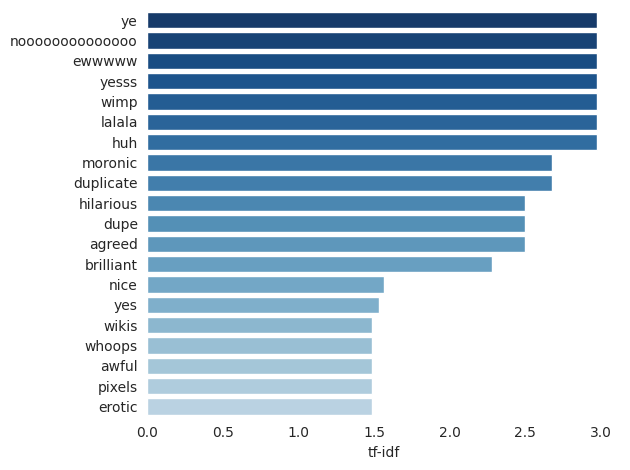

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

no_words = 20

# Plots a bar chart visualizing the top 20 words with highest tf-idf score.
fig = sns.barplot(data=token_tf_idf_pd.head(no_words), x='tf-idf', y='token', orient='h', palette=sns.color_palette('Blues_r',no_words+8))
sns.set_style("white")
sns.despine(left=True, bottom=True)
fig.set(ylabel=None)
plt.tight_layout()
plt.savefig("top_tf_idf_words.png")

In [21]:
spark.stop()